In [2]:
%load_ext autoreload
%autoreload 

In [3]:

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
from pathlib import Path
import time

import colorcet
os.chdir('/home/ali/packages/s2p-lbm/')


In [4]:



def get_frame_timings(vox_per_row, n_rows_per_strip, n_strips, row_period_s, temporal_fill_frac, strip_flyback_s, frame_flyback_s):
    n_voxels = int(vox_per_row * n_rows_per_strip * n_strips)
    row_start_offset = row_period_s * (1 - temporal_fill_frac) / 2
    row_vox_times = n.arange(vox_per_row) * voxel_time_s + row_start_offset
    frame_voxel_times = n.zeros(n_voxels)
    frame_strip_times = []
    voxel_idx = 0
    t_curr = 0
    for strip_idx in range(n_strips):
        strip_start_time = t_curr
        for row_idx in range(n_rows_per_strip):
            row_start_time = t_curr
            frame_voxel_times[voxel_idx:voxel_idx + vox_per_row] = t_curr + row_vox_times
            t_curr += row_period_s
            voxel_idx += vox_per_row
        strip_end_time = t_curr
        frame_strip_times.append((strip_start_time,strip_end_time))
        if strip_idx < n_strips - 1:
            t_curr += strip_flyback_s
            # break
    t_curr += frame_flyback_s
    frame_strip_times = n.array(frame_strip_times)

    return frame_voxel_times, frame_strip_times

In [5]:

# use the fact that the resonant is sinusoidal to compute its amplitude according to voxel size and number of voxels
def calculate_resonant_amplitude(resonant_period, temporal_fill_frac, xsize_um, vox_per_row):
    row_period_s = resonant_period / 2
    row_start_offset = (resonant_period/2) * (1 - temporal_fill_frac) / 2
    res_ts = n.linspace(0, resonant_period, 201)
    normalized_res_xs = get_resonant_position(res_ts, resonant_period)
    normalized_start_x = normalized_res_xs[n.argmin(n.abs(res_ts - row_start_offset))]
    normalized_end_x = normalized_res_xs[n.argmin(n.abs(res_ts - (row_period_s - row_start_offset)))]
    normalized_range = n.abs(normalized_start_x - normalized_end_x)
    real_range = xsize_um * vox_per_row
    resonant_amplitude = real_range / normalized_range 
    res_start_x = resonant_amplitude * normalized_start_x
    res_end_x = resonant_amplitude * normalized_end_x

    other_values = {
        'row_start_offset_s' : row_start_offset,
        'normalized_start_x' : normalized_start_x,
        'normalized_end_x' : normalized_end_x,
        'normalized_range' : normalized_range,
        'start_x' : res_start_x,
        'end_x' : res_end_x,
        'range' : real_range
    }
    
    return resonant_amplitude, other_values
def get_resonant_position(time, resonant_period, resonant_amplitude=1):
    normalized_position = -n.sin(2 * n.pi * time / (resonant_period) + n.pi/2) / 2 + 0.5
    return normalized_position * resonant_amplitude


In [6]:
def get_galvo_position(time, frame_strip_times, strip_height_um, strip_spacing_um):
    time = n.array(time)
    if len(time.shape) == 0:
        time = n.array([time])
    assert len(time.shape) == 1
    nt = len(time)

    pos = n.zeros((nt, 2)) * n.nan
    
    for strip_idx, (s_start, s_end) in enumerate(frame_strip_times):
        times_in_strip = n.logical_and(time >= s_start, time < s_end)
        pos[times_in_strip,0] = strip_height_um * (time[times_in_strip] - s_start) / (s_end - s_start)
        pos[times_in_strip,1] = strip_idx * strip_spacing_um


    return pos

In [7]:
def get_scan_position(time, frame_strip_times, strip_height_um, strip_spacing_um, resonant_period, resonant_amplitude):
    galvo_pos = get_galvo_position(time, frame_strip_times, strip_height_um, strip_spacing_um)
    galvo_pos[:,1] += get_resonant_position(time, resonant_period, resonant_amplitude)
    return galvo_pos

In [8]:
# size of a voxel
xsize_um = 1
ysize_um = 1

# number of voxels in a resonant scanner row
vox_per_row = 128
# fraction of time recording during a row
temporal_fill_frac = 0.71
# frequency of the resonant mirror
# (time require to complete two rows)
resonant_freq_hz = 12e3

# number of imaging strips
n_strips = 2
# lateral spacing between two rows in neighboring strips
strip_spacing_um = 128
# height of a strip
strip_height_um = 200
# amount of time from end of one strip to start of next
strip_flyback_s = 0.001
# amount of time from end of last strip of one frame to start of next frame
frame_flyback_s = 0.005

# amount of time to complete one row
resonant_period_s = 1 / resonant_freq_hz
row_period_s = 1 / (2 * resonant_freq_hz)
# dwell time on each voxel
voxel_time_s = row_period_s * temporal_fill_frac / vox_per_row

assert strip_height_um % ysize_um == 0
n_rows_per_strip = int(strip_height_um / ysize_um)
strip_duration = n_rows_per_strip * row_period_s
frame_duration = strip_duration * n_strips + (n_strips - 1) * strip_flyback_s + frame_flyback_s
frame_rate = 1 / frame_duration

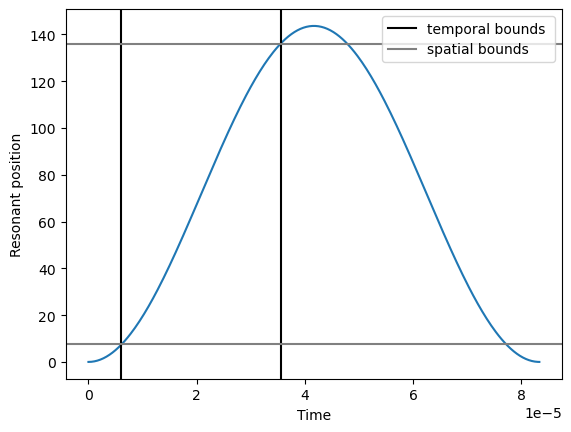

In [9]:
resonant_amplitude, resonant_values = calculate_resonant_amplitude(resonant_period_s, temporal_fill_frac, xsize_um, vox_per_row)



res_ts = n.linspace(0,resonant_period_s, 301)
f,ax = plt.subplots()
ax.plot(res_ts, get_resonant_position(res_ts, resonant_period_s, resonant_amplitude))
ax.axvline(resonant_values['row_start_offset_s'], color='k', label='temporal bounds ')
ax.axvline(row_period_s - resonant_values['row_start_offset_s'], color='k')
ax.axhline(resonant_values['start_x'], color='grey', label='spatial bounds')
ax.axhline(resonant_values['end_x'], color='grey')
ax.set_ylabel("Resonant position")
ax.set_xlabel("Time")
ax.legend()

In [10]:
frame_voxel_times, frame_strip_times = get_frame_timings(vox_per_row, n_rows_per_strip, n_strips, row_period_s, temporal_fill_frac, strip_flyback_s, frame_flyback_s)

In [11]:
scan_pos = get_scan_position(frame_voxel_times, frame_strip_times, strip_height_um, strip_spacing_um, resonant_period_s, resonant_amplitude)

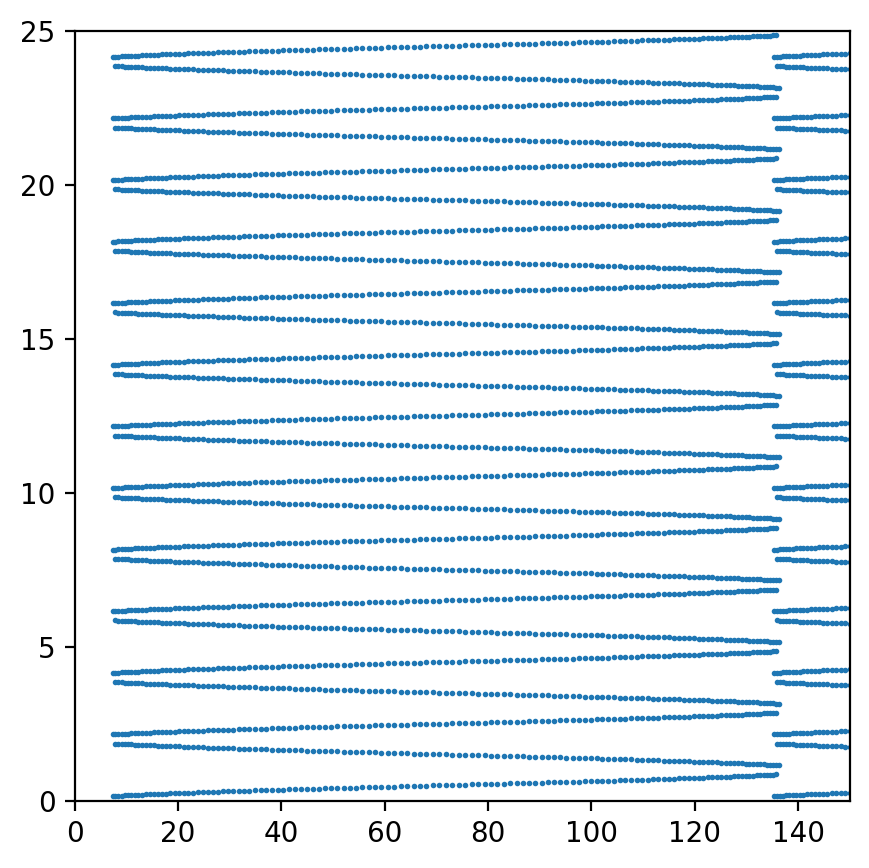

In [15]:
f,ax=plt.subplots(figsize=(5,5), dpi=200)
ax.set_xlim(0,150)
ax.set_ylim(0,25)
ax.scatter(scan_pos[:,1], scan_pos[:,0], s=1)

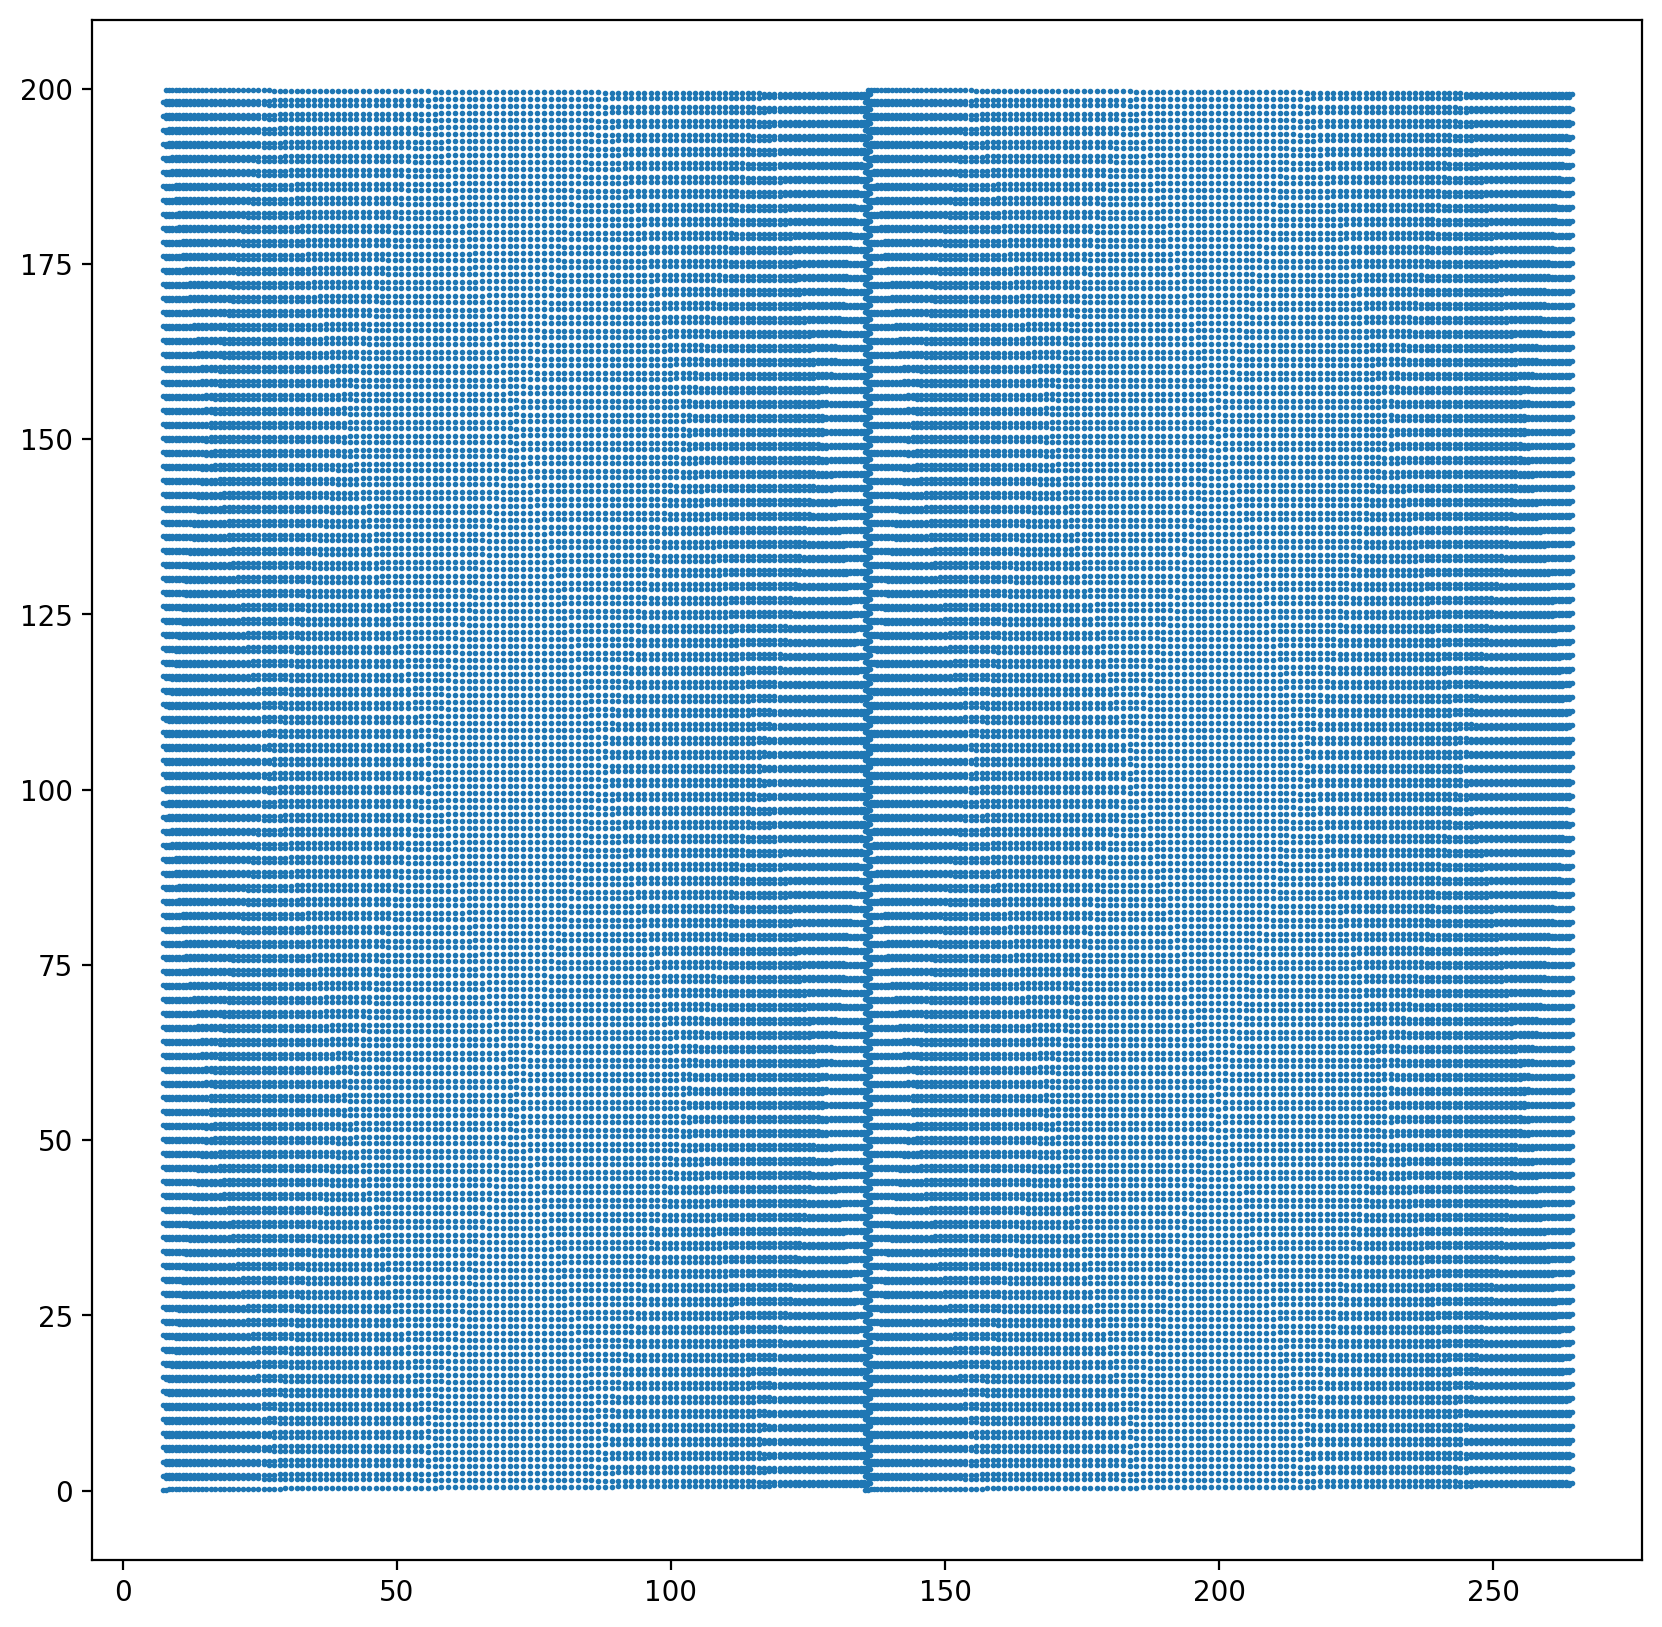

In [244]:
f,ax=plt.subplots(figsize=(10,10), dpi=200)
ax.scatter(scan_pos[:,1], scan_pos[:,0], s=1)

In [189]:
scan_pos.shape

(51200, 2)